In [ ]:
# %pip install human-learn

In [1]:
from hulearn.datasets import load_titanic
import pandas as pd
import numpy as np

df = load_titanic(as_frame=True)
X, y = df.drop(columns=['survived']), df['survived']

def fare_based(dataf, threshold=10):
    return np.array(dataf['fare'] > threshold).astype(int)

In [2]:
df

,survived,pclass,name,sex,age,fare,sibsp,parch
0,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,0,0
...,...,...,...,...,...,...,...,...
709,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,29.1250,0,5
710,0,2,"Montvila, Rev. Juozas",male,27.0,13.0000,0,0
711,1,1,"Graham, Miss. Margaret Edith",female,19.0,30.0000,0,0
712,1,1,"Behr, Mr. Karl Howell",male,26.0,30.0000,0,0


In [3]:
from hulearn.classification import FunctionClassifier
# This next line of code changes the function into a proper scikit-learn compatible model.
mod = FunctionClassifier(fare_based, threshold=10)

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer

grid = GridSearchCV(mod,
                    cv=2,
                    param_grid={'threshold': np.linspace(0, 100, 30)},
                    scoring={'accuracy': make_scorer(accuracy_score),
                            'precision': make_scorer(precision_score),
                            'recall': make_scorer(recall_score)},
                    refit='accuracy'
                )
grid.fit(X, y)

GridSearchCV(cv=2,
             estimator=FunctionClassifier(func=<function fare_based at 0x7f2a3458f820>,
                                          threshold=10),
             param_grid={'threshold': array([  0.        ,   3.44827586,   6.89655172,  10.34482759,
        13.79310345,  17.24137931,  20.68965517,  24.13793103,
        27.5862069 ,  31.03448276,  34.48275862,  37.93103448,
        41.37931034,  44.82758621,  48.27586207,  51.72413793,
        55.17241379,  58.62068966,  62.06896552,  65.51724138,
        68.96551724,  72.4137931 ,  75.86206897,  79.31034483,
        82.75862069,  86.20689655,  89.65517241,  93.10344828,
        96.55172414, 100.        ])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

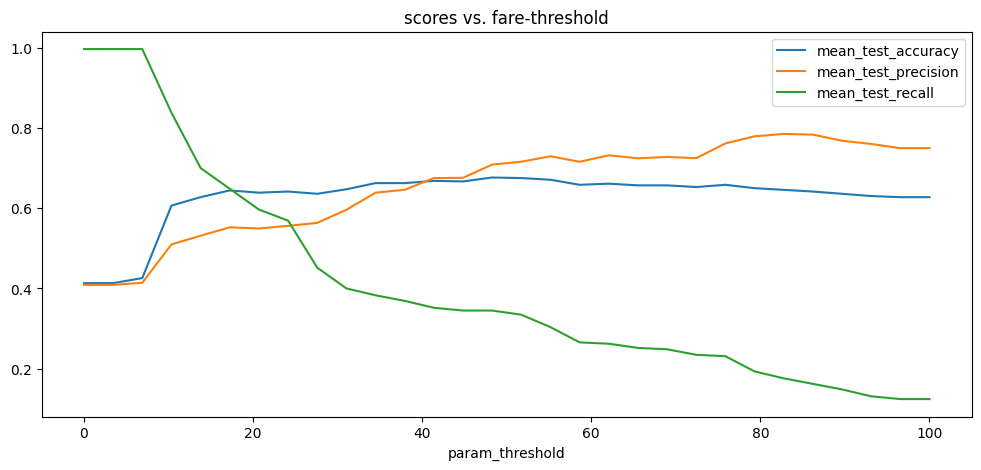

In [5]:
score_df = (pd.DataFrame(grid.cv_results_)
  .set_index('param_threshold')
  [['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']])

score_df.plot(figsize=(12, 5), title="scores vs. fare-threshold");

In [ ]:
# Example to make decision

# These two models are assumed to be trained beforehand.
outlier    = WhatEverOutlierDetector().fit(X, y)
classifier = WhatEverClassifier().fit(X, y)

def make_decision(dataf, proba_threshold=0.8):
    # First we create a resulting array with all the predictions
    res = classifier.predict(dataf)

    # If we detect doubt, "classify" it as a fallback instead.
    proba = classifier.predict_proba(dataf)
    res = np.where(proba.max(axis=1) < proba_threshold, "doubt_fallback", res)

    # If we detect an outlier, we'll fallback too.
    res = np.where(outlier.predict(dataf) == -1, "outlier_fallback", res)

    # This `res` array contains the output of the drawn diagram.
    return res

fallback_model = FunctionClassifier(make_decision, proba_threshold=0.8)